# skyfield 示例

计算恒星的观测位置 <br>

https://rhodesmill.org/skyfield/ <br>

https://rhodesmill.org/skyfield/stars.html <br>

https://rhodesmill.org/skyfield/positions.html<br>

In [62]:
import numpy as np
# import ephem
from astropy.coordinates import EarthLocation
from  astropy import units

In [63]:
def lla_to_ecef(lat, lon, alt):
    """Convert WGS84 spherical coordinates to ECEF cartesian coordinates.
    :param lat:
    :param lon:
    :param alt:
    :result ecef:
    """
    WGS84_a = 6378137.00000000
    WGS84_b = 6356752.31424518
    N = WGS84_a**2 / np.sqrt(
        WGS84_a**2 * np.cos(lat) ** 2 + WGS84_b**2 * np.sin(lat) ** 2
    )

    x = (N + alt) * np.cos(lat) * np.cos(lon)
    y = (N + alt) * np.cos(lat) * np.sin(lon)
    z = ((WGS84_b**2 / WGS84_a**2) * N + alt) * np.sin(lat)

    return x, y, z
def ecef_to_enu(location, xyz):
    """Convert ECEF coordinates to ENU coordinates relative to reference location.
    :param location: Current WGS84 coordinate
    :param xyz: ECEF coordinate
    :result : enu
    """
    # ECEF coordinates of reference point
    lon = location.geodetic[0].to(units.rad).value
    lat = location.geodetic[1].to(units.rad).value
    alt = location.geodetic[2].to(units.m).value
    x, y, z = np.hsplit(xyz, 3)  # pylint: disable=unbalanced-tuple-unpacking

    center_x, center_y, center_z = lla_to_ecef(lat, lon, alt)

    delta_x, delta_y, delta_z = x - center_x, y - center_y, z - center_z
    sin_lat, cos_lat = np.sin(lat), np.cos(lat)
    sin_lon, cos_lon = np.sin(lon), np.cos(lon)

    e = -sin_lon * delta_x + cos_lon * delta_y
    n = -sin_lat * cos_lon * delta_x - sin_lat * sin_lon * delta_y + cos_lat * delta_z
    u = cos_lat * cos_lon * delta_x + cos_lat * sin_lon * delta_y + sin_lat * delta_z

    return np.hstack([e, n, u])

def xyz_at_latitude(local_xyz, lat):
    """
    Rotate local XYZ coordinates into celestial XYZ coordinates. These
    coordinate systems are very similar, with X pointing towards the
    geographical east in both cases. However, before the rotation Z
    points towards the zenith, whereas afterwards it will point towards
    celestial north (parallel to the earth axis).

    :param lat: target latitude (radians or astropy quantity)
    :param local_xyz: Array of local XYZ coordinates
    :return: Celestial XYZ coordinates
    """

    # return enu_to_eci(local_xyz, lat)
    x, y, z = np.hsplit(local_xyz, 3)  # pylint: disable=unbalanced-tuple-unpacking

    lat2 = np.pi / 2 - lat
    y2 = -z * np.sin(lat2) + y * np.cos(lat2)
    z2 = z * np.cos(lat2) + y * np.sin(lat2)

    return np.hstack([x, y2, z2])
def xyz_to_uvw(xyz, ha, dec):
    """
    Rotate :math:`(x,y,z)` positions in earth coordinates to
    :math:`(u,v,w)` coordinates relative to astronomical source
    position :math:`(ha, dec)`. Can be used for both antenna positions
    as well as for baselines.

    Hour angle and declination can be given as single values or arrays
    of the same length. Angles can be given as radians or astropy
    quantities with a valid conversion.

    :param xyz: :math:`(x,y,z)` co-ordinates of antennas in array
    :param ha: hour angle of phase tracking centre (:math:`ha = ra - lst`)
    :param dec: declination of phase tracking centre.
    """

    # return eci_to_uvw(xyz, ha, dec)
    x, y, z = np.hsplit(xyz, 3)  # pylint: disable=unbalanced-tuple-unpacking

    # Two rotations:
    #  1. by 'ha' along the z axis
    #  2. by '90-dec' along the u axis
    u = x * np.cos(ha) - y * np.sin(ha)
    v0 = x * np.sin(ha) + y * np.cos(ha)
    w = z * np.sin(dec) - v0 * np.cos(dec)
    v = z * np.cos(dec) + v0 * np.sin(dec)

    return np.hstack([u, v, w])

测站坐标，南纬70度、西经30度、海拔2378米

In [64]:
latitude_degrees = -30.712925   # latitude in degrees; north positive.
longitude_degrees = 21.443803  # longitude in degrees; east positive.
elevation_m = 1053.000000      # Height of the observer (meters).
temperature_C = 10.0       # Temperature (degrees Celcius).
pressure_mbar = 1010.0     # Atmospheric pressure (millibars).


In [65]:
mid_location = EarthLocation(
        lon=longitude_degrees * units.deg, lat=latitude_degrees * units.deg, height=elevation_m
    )

In [66]:
import skyfield

print('skyfield version: ', skyfield.__version__)


skyfield version:  1.46


注意：路径，主要包含 JPL DE 星历文件 “de421.bsp” 和 EOP 文件 “finals2000A.all”，以及 HIP 星表文件 “hip_main.dat”

In [67]:
from skyfield import api
from skyfield.api import Topos
from skyfield.api import load

__skyfield_data__ = 'skyfield-data'
load = api.Loader(__skyfield_data__)


创建测站

In [68]:
# observer
from skyfield.api import wgs84
from skyfield.vectorlib import VectorSum
planets = load('de421.bsp')
earth: VectorSum = planets['earth']

obser: VectorSum = earth + \
    wgs84.latlon(latitude_degrees, longitude_degrees, elevation_m)


载入 HIP 星表

In [69]:
# load hipparcos catalog
# ICRS, J1991.25
from skyfield.starlib import Star
from skyfield.data import hipparcos
with load.open('hip_main.dat') as f:
    df = hipparcos.load_dataframe(f)


设定星号

In [70]:
# set hip id
hipid = 46701


从星表中获取对应的恒星，输出星表中的 ra、dec、pmRA、pmDE、plx、RV

特别说明：HIP 星表的坐标系为 ICRS，历元时刻为 J1991.25（JD=2448349.0625）

In [71]:
df.loc[hipid]

magnitude              3.160000
ra_degrees           142.805641
dec_degrees          -57.034392
parallax_mas          13.720000
ra_mas_per_year      -32.580000
dec_mas_per_year       6.080000
ra_hours               9.520376
epoch_year          1991.250000
Name: 46701, dtype: float64

In [20]:
import copy

In [21]:
offset_df = copy.deepcopy(df.loc[hipid])
print(180./3.1415926535758989*0.03)

1.7188733854000717


In [22]:
offset_df['dec_degrees'] += np.rad2deg(0.03)

In [23]:
offset_df

magnitude              3.160000
ra_degrees           142.805641
dec_degrees          -55.315518
parallax_mas          13.720000
ra_mas_per_year      -32.580000
dec_mas_per_year       6.080000
ra_hours               9.520376
epoch_year          1991.250000
Name: 46701, dtype: float64

In [74]:
# get star with ID=46701
star = Star.from_dataframe(df.loc[hipid])
offset_star = Star.from_dataframe(offset_df)
print(type(star))
print('epoch: ', star.epoch)
print('Catalog:', star.ra, star.dec, star.ra_mas_per_year, star.dec_mas_per_year,
      star.parallax_mas, star.radial_km_per_s)


<class 'skyfield.starlib.Star'>
epoch:  2448349.0625
Catalog: 09h 31m 13.35s -57deg 02' 03.8" -32.58 6.08 13.72 0.0


In [25]:
star

Star(ra=142.80564072, dec=-57.0343916, ra_mas_per_year=-32.58, dec_mas_per_year=6.08, parallax_mas=13.72, epoch=2448349.0625)

In [26]:
offset_star

Star(ra=142.80564072, dec=-55.31551821460753, ra_mas_per_year=-32.58, dec_mas_per_year=6.08, parallax_mas=13.72, epoch=2448349.0625)

是否考虑 dUT1，实际应用需要考虑，因我之前的程序为考虑 dUT1，为了比对，特设定该参数。

In [75]:
ignore_dUT1 = True


In [76]:
# Create a timescale and ask the current time.
if ignore_dUT1:
    # delta_t=32.184+37=69.184, dUT1=UT1-UTC=0.0
    ts = load.timescale(builtin=False, delta_t=69.184)
else:
    ts = load.timescale(builtin=False)


设定观测时刻

In [77]:
# dUT1=0 if ignore_dUT1 is True
# 按IERS公报，dUT1=-0.2429
t = ts.utc(2020, 5, 1, 23, 0, 0.0)
print('utc: ', t.utc)
print('delta_t:', t.delta_t)  # 32.184+37-(-0.2429)=69.4269
print('dUT1=Ut1-UTC:', t.dut1)    # -0.2429
print('TT:', t.tt)


utc:  CalendarTuple(year=2020, month=5, day=1, hour=23, minute=0, second=0.0)
delta_t: 69.184
dUT1=Ut1-UTC: 0.0
TT: 2458971.459134074


In [30]:
t 

<Time tt=2458971.459134074>

计算恒星的天文位置：光行差改正（light-time correction, vectorlib._correct_for_light_travel_time），当然包含了恒星自行、视向速度等效应

In [78]:
astrometric = obser.at(t).observe(star)
print(astrometric.xyz)
print(astrometric.light_time)
astrometric_offset = obser.at(t).observe(offset_star)

[ -6516439.81912468   4945323.83504173 -12613376.29923986] au
86828.43600256063


计算恒星的视位置：引力弯曲（deflection）、观测站的空间运动效应（aberration）

In [79]:
apparent = astrometric.apparent()
apparent_offset = astrometric_offset.apparent()

计算不同坐标系下的赤经赤纬 <br>
(1) ICRF坐标系到J2000坐标系：bias修正<br>
(2) J2000坐标系到真赤道真春分点date坐标系：岁差章动自转极移 <br>

HIP 46701 在 UTC 2020-05-01 23:00:00 时刻的真赤道真春分点date坐标系下的赤经赤纬如下：<br>
date : 09h 31m 50.18s -57deg 07' 42.3" <br>

我之前的预报软件的结果（不考虑dUT1）： RA 09h 31m 50.174s -57deg 07' 42.228" <br>

In [80]:
# ICRF
ra, dec, d = apparent.radec()
print('ICRF :', ra, dec)
# J2000
ra, dec, d = apparent.radec(ts.J2000)
print('J2000 :', ra, dec)
# 站心真赤道真春分点坐标系
ra, dec, d = apparent.radec('date')
print('date :', ra, dec)


ICRF : 09h 31m 13.63s -57deg 02' 23.2"
J2000 : 09h 31m 13.60s -57deg 02' 22.3"
date : 09h 31m 50.18s -57deg 07' 42.5"


In [34]:
# ICRF
ra_off, dec_off, d_off = apparent_offset.radec()
print('ICRF :', ra_off, dec_off)
# J2000
ra_off, dec_off, d_off = apparent_offset.radec(ts.J2000)
print('J2000 :', ra_off, dec_off)
# 站心真赤道真春分点坐标系
ra_off, dec_off, d_off = apparent_offset.radec('date')
print('date :', ra_off, dec_off)

ICRF : 09h 31m 13.62s -55deg 19' 15.1"
J2000 : 09h 31m 13.53s -55deg 19' 14.2"
date : 09h 31m 51.73s -55deg 24' 34.4"


计算站心地平系下的方位俯仰。<br>

不考虑dUT1情况下，HIP 46701 在 UTC 2020-05-01 23:00:00 时刻的方位俯仰如下：<br>
alt az (no atmos)  :  70deg 49' 24.5" 298deg 31' 06.5" <br>

我之前的预报软件的结果（不考虑大气折射、不考虑dUT1）： Alt 70deg 49' 24.381" Az 298deg 31' 06.332" <br>

In [35]:
# 不考虑大气折射改正
alt, az, d = apparent.altaz()
print('alt az (no atmos)  : ', alt, az)

# # 考虑大气折射改正
# alt, az, d = apparent.altaz(temperature_C, pressure_mbar)
# print('alt az (with atmos): ', alt, az)


alt az (no atmos)  :  28deg 38' 17.9" 217deg 56' 16.3"


In [36]:
# 不考虑大气折射改正
alt_off, az_off, d_off = apparent_offset.altaz()
print('alt az (no atmos)  : ', alt_off, az_off)

# # 考虑大气折射改正
# alt_off, az_off, d_off = apparent_offset.altaz(temperature_C, pressure_mbar)
# print('alt az (with atmos): ', alt_off, az_off)


alt az (no atmos)  :  28deg 14' 17.5" 219deg 50' 20.4"


In [37]:
apparent.radec()

(<Angle 09h 31m 13.63s>, <Angle -57deg 02' 23.2">, <Distance 1.50339e+07 au>)

In [38]:
az_off.radians

3.8369143875232137

In [39]:
def azel_to_enu(az_rad, el_rad):
    sin_az, cos_az = np.sin(az_rad), np.cos(az_rad)
    sin_el, cos_el = np.sin(el_rad), np.cos(el_rad)
    return sin_az * cos_el, cos_az * cos_el, sin_el

In [40]:
def kapoint_rotation(az,el,offset_az,offset_el,offset_sign):
    w = np.array(azel_to_enu(az, el))
    # enu vector pointing from reference antenna to offset point
    z = np.array(azel_to_enu(offset_az, offset_el))
    # u axis is orthogonal to z and w, and row_stack makes it 2-D array of column vectors
    u = np.row_stack(np.cross(z, w, axis=0)) * offset_sign
    u_norm = np.sqrt(np.sum(u ** 2, axis=0))
    # Ensure that u and w (and therefore v) have the same shape to handle scalar vs array output correctly
    u = u.reshape(w.shape) / u_norm
    v = np.cross(w, u, axis=0)
    return np.array([u, v, w])

In [41]:
katrot = kapoint_rotation(az.radians,alt.radians,az_off.radians,alt_off.radians,1)

In [42]:
# ska-mid enu

In [43]:
midcfg="/home/wangfeng/work/rascil2/data/configurations/ska1mid.cfg"

In [44]:
with open(midcfg,"r") as f:
    mid = f.readlines()

In [45]:
midconfig = []
for line in mid:
    if "#" in line:
        continue
    else:
        midconfig.append(
            list(map(float,line.strip().split()[:3]))
        )

In [46]:
midconfig_XYZ = np.array(midconfig)

In [47]:
midconfig_ENU = ecef_to_enu(mid_location,midconfig_XYZ)

In [48]:
midconfig_ENU[0][None].T.shape

(3, 1)

In [49]:
UVW_katpoint = np.dot(katrot[None,...], midconfig_ENU[:,:,None])

In [50]:
apparent.hadec()[0].radians

1.4627571176157996

In [51]:
xyzatlat = xyz_at_latitude(midconfig_ENU,np.deg2rad(latitude_degrees))
UVW_rascil = xyz_to_uvw(xyzatlat,apparent.hadec()[0].radians,apparent.hadec()[1].radians)

In [52]:
help(apparent.hadec)

Help on method hadec in module skyfield.positionlib:

hadec() method of skyfield.positionlib.Apparent instance
    Compute hour angle, declination, and distance.
    
    Returns a tuple of two :class:`~skyfield.units.Angle` objects
    plus the :class:`~skyfield.units.Distance` to the target.  The
    angles are the hour angle (±12 hours) east or west of your
    meridian along the ITRS celestial equator, and the declination
    (±90 degees) above or below it.  This only works for positions
    whose center is a geographic location; otherwise, there is no
    local meridian from which to measure the hour angle.
    
    Because this declination is measured from the plane of the
    Earth’s physical geographic equator, it will be slightly
    different than the declination returned by ``radec()`` if you
    have loaded a :ref:`polar motion` file.
    
    The coordinates are not adjusted for atmospheric refraction near
    the horizon.



In [53]:
apparent.hadec()

(<Angle 05h 35m 14.35s>, <Angle -57deg 07' 42.5">, <Distance 1.50339e+07 au>)

In [54]:
apparent.radec('date')

(<Angle 09h 31m 50.18s>, <Angle -57deg 07' 42.5">, <Distance 1.50339e+07 au>)

In [55]:
res = UVW_katpoint[0,:,:,0].T - UVW_rascil

In [56]:
import matplotlib.pyplot as plt

In [57]:
res.shape

(197, 3)

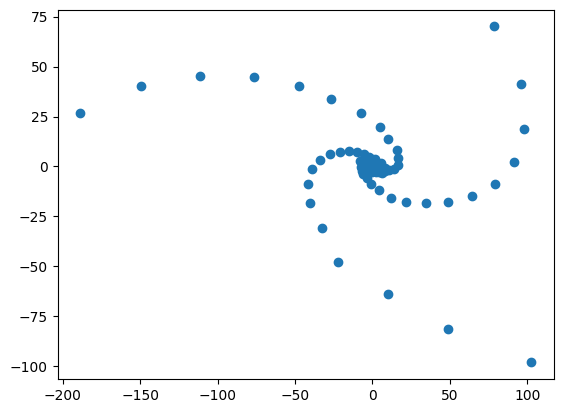

In [58]:
plt.scatter(res[:,0],res[:,1])

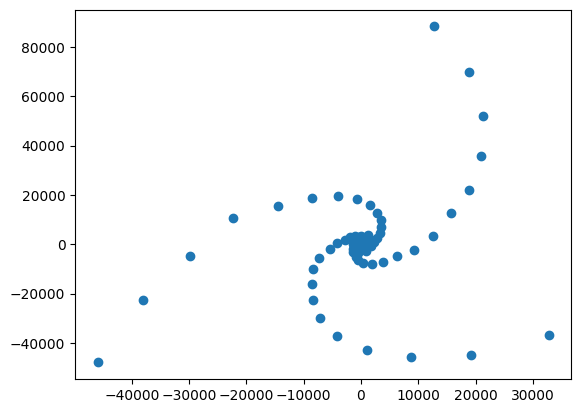

In [59]:
plt.scatter(UVW_rascil[:,0],UVW_rascil[:,1])

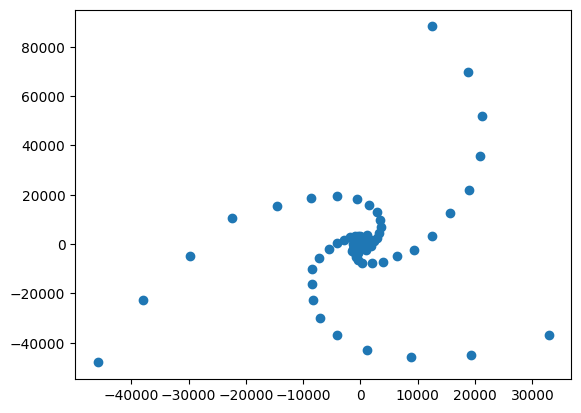

In [60]:
plt.scatter(UVW_katpoint[0,:,:,0].T[:,0],UVW_katpoint[0,:,:,0].T[:,1])

In [61]:
UVW_katpoint[0,:,:,0].T[:,0].shape

(197,)